## BO with TuRBO-1 and TS/qEI

In this tutorial, we show how to implement Trust Region Bayesian Optimization (TuRBO) [1] in a closed loop in BoTorch.

This implementation uses one trust region (TuRBO-1) and supports either parallel expected improvement (qEI) or Thompson sampling (TS). We optimize the $20D$ Ackley function on the domain $[-5, 10]^{20}$ and show that TuRBO-1 outperforms qEI as well as Sobol.

Since botorch assumes a maximization problem, we will attempt to maximize $-f(x)$ to achieve $\max_x -f(x)=0$.

[1]: [Eriksson, David, et al. Scalable global optimization via local Bayesian optimization. Advances in Neural Information Processing Systems. 2019](https://proceedings.neurips.cc/paper/2019/file/6c990b7aca7bc7058f5e98ea909e924b-Paper.pdf)


In [ ]:
# Install dependencies if we are running in colab
import sys
if 'google.colab' in sys.modules:
    %pip install botorch

In [1]:
import os
import math
import warnings
from dataclasses import dataclass

import torch
from botorch.acquisition import qExpectedImprovement, qLogExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize
from torch.quasirandom import SobolEngine

import gpytorch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood


warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


## Optimize the 20-dimensional Ackley function

The goal is to minimize the popular Ackley function:

$f(x_1,\ldots,x_d) = -20\exp\left(-0.2 \sqrt{\frac{1}{d} \sum_{j=1}^d x_j^2} \right) -\exp \left( \frac{1}{d} \sum_{j=1}^d \cos(2 \pi x_j) \right) + 20 + e$

over the domain  $[-5, 10]^{20}$.  The global optimal value of $0$ is attained at $x_1 = \ldots = x_d = 0$.

As mentioned above, since botorch assumes a maximization problem, we instead maximize $-f(x)$.

In [2]:
fun = Ackley(dim=20, negate=True).to(dtype=dtype, device=device)
fun.bounds[0, :].fill_(-5)
fun.bounds[1, :].fill_(10)
dim = fun.dim
lb, ub = fun.bounds

batch_size = 4
n_init = 2 * dim
max_cholesky_size = float("inf")  # Always use Cholesky


def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return fun(unnormalize(x, fun.bounds))

## Maintain the TuRBO state
TuRBO needs to maintain a state, which includes the length of the trust region, success and failure counters, success and failure tolerance, etc. 

In this tutorial we store the state in a dataclass and update the state of TuRBO after each batch evaluation. 

**Note**: These settings assume that the domain has been scaled to $[0, 1]^d$ and that the same batch size is used for each iteration.

In [3]:
@dataclass
class TurboState:
    dim: int
    batch_size: int
    length: float = 0.8
    length_min: float = 0.5**7
    length_max: float = 1.6
    failure_counter: int = 0
    failure_tolerance: int = float("nan")  # Note: Post-initialized
    success_counter: int = 0
    success_tolerance: int = 10  # Note: The original paper uses 3
    best_value: float = -float("inf")
    restart_triggered: bool = False

    def __post_init__(self):
        self.failure_tolerance = math.ceil(
            max([4.0 / self.batch_size, float(self.dim) / self.batch_size])
        )


def update_state(state, Y_next):
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1

    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0

    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state

## Take a look at the state

In [4]:
state = TurboState(dim=dim, batch_size=batch_size)
print(state)

TurboState(dim=20, batch_size=4, length=0.8, length_min=0.0078125, length_max=1.6, failure_counter=0, failure_tolerance=5, success_counter=0, success_tolerance=10, best_value=-inf, restart_triggered=False)


## Generate initial points
This generates an initial set of Sobol points that we use to start of the BO loop.

In [5]:
def get_initial_points(dim, n_pts, seed=0):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = sobol.draw(n=n_pts).to(dtype=dtype, device=device)
    return X_init

## Generate new batch
Given the current `state` and a probabilistic (GP) `model` built from observations `X` and `Y`, we generate a new batch of points.  

This method works on the domain $[0, 1]^d$, so make sure to not pass in observations from the true domain.  `unnormalize` is called before the true function is evaluated which will first map the points back to the original domain.

We support either TS and qEI which can be specified via the `acqf` argument.

In [6]:
def generate_batch(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    batch_size,
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts", "ei")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the TR to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)

    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates).to(dtype=dtype, device=device)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = torch.rand(n_candidates, dim, dtype=dtype, device=device) <= prob_perturb
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim - 1, size=(len(ind),), device=device)] = 1

        # Create candidate points from the perturbations and the mask
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        with torch.no_grad():  # We don't need gradients when using TS
            X_next = thompson_sampling(X_cand, num_samples=batch_size)

    elif acqf == "ei":
        ei = qExpectedImprovement(model, train_Y.max())
        X_next, acq_value = optimize_acqf(
            ei,
            bounds=torch.stack([tr_lb, tr_ub]),
            q=batch_size,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
        )

    return X_next

## Optimization loop
This simple loop runs one instance of TuRBO-1 with Thompson sampling until convergence.

TuRBO-1 is a local optimizer that can be used for a fixed evaluation budget in a multi-start fashion.  Once TuRBO converges, `state["restart_triggered"]` will be set to true and the run should be aborted.  If you want to run more evaluations with TuRBO, you simply generate a new set of initial points and then keep generating batches until convergence or when the evaluation budget has been exceeded.  It's important to note that evaluations from previous instances are discarded when TuRBO restarts.

NOTE: We use a `SingleTaskGP` with a noise constraint to keep the noise from getting too large as the problem is noise-free. 

In [7]:
X_turbo = get_initial_points(dim, n_init)
Y_turbo = torch.tensor(
    [eval_objective(x) for x in X_turbo], dtype=dtype, device=device
).unsqueeze(-1)

state = TurboState(dim, batch_size=batch_size, best_value=max(Y_turbo).item())

NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4
N_CANDIDATES = min(5000, max(2000, 200 * dim)) if not SMOKE_TEST else 4

torch.manual_seed(0)

while not state.restart_triggered:  # Run until TuRBO converges
    # Fit a GP model
    train_Y = (Y_turbo - Y_turbo.mean()) / Y_turbo.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(
            nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0)
        )
    )
    model = SingleTaskGP(
        X_turbo, train_Y, covar_module=covar_module, likelihood=likelihood
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # Do the fitting and acquisition function optimization inside the Cholesky context
    with gpytorch.settings.max_cholesky_size(max_cholesky_size):
        # Fit the model
        fit_gpytorch_mll(mll)

        # Create a batch
        X_next = generate_batch(
            state=state,
            model=model,
            X=X_turbo,
            Y=train_Y,
            batch_size=batch_size,
            n_candidates=N_CANDIDATES,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            acqf="ts",
        )

    Y_next = torch.tensor(
        [eval_objective(x) for x in X_next], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Update state
    state = update_state(state=state, Y_next=Y_next)

    # Append data
    X_turbo = torch.cat((X_turbo, X_next), dim=0)
    Y_turbo = torch.cat((Y_turbo, Y_next), dim=0)

    # Print current status
    print(
        f"{len(X_turbo)}) Best value: {state.best_value:.2e}, TR length: {state.length:.2e}"
    )

44) Best value: -1.17e+01, TR length: 8.00e-01
48) Best value: -1.17e+01, TR length: 8.00e-01
52) Best value: -1.12e+01, TR length: 8.00e-01
56) Best value: -1.04e+01, TR length: 8.00e-01
60) Best value: -1.04e+01, TR length: 8.00e-01
64) Best value: -9.42e+00, TR length: 8.00e-01
68) Best value: -9.42e+00, TR length: 8.00e-01
72) Best value: -9.42e+00, TR length: 8.00e-01
76) Best value: -9.42e+00, TR length: 8.00e-01
80) Best value: -8.75e+00, TR length: 8.00e-01
84) Best value: -8.75e+00, TR length: 8.00e-01
88) Best value: -8.75e+00, TR length: 8.00e-01
92) Best value: -8.75e+00, TR length: 8.00e-01
96) Best value: -8.27e+00, TR length: 8.00e-01
100) Best value: -8.27e+00, TR length: 8.00e-01
104) Best value: -8.27e+00, TR length: 8.00e-01
108) Best value: -8.27e+00, TR length: 8.00e-01
112) Best value: -8.27e+00, TR length: 8.00e-01
116) Best value: -8.27e+00, TR length: 4.00e-01
120) Best value: -6.45e+00, TR length: 4.00e-01
124) Best value: -6.45e+00, TR length: 4.00e-01
128) B

## GP-LogEI
We compare TuRBO to qLogEI [2], a recent improvement to the expected improvement (EI) acquisition functions.

[2]: [Ament, Sebastian, et al., Unexpected Improvements to Expected Improvement for Bayesian Optimization. Advances in Neural Information Processing Systems. 2023](https://proceedings.neurips.cc/paper_files/paper/2023/file/419f72cbd568ad62183f8132a3605a2a-Paper-Conference.pdf)



In [8]:
torch.manual_seed(0)

X_logei = get_initial_points(dim, n_init)
Y_logei = torch.tensor(
    [eval_objective(x) for x in X_logei], dtype=dtype, device=device
).unsqueeze(-1)

# Cap the number of evals when running smoke test
max_evals = min(len(Y_turbo), n_init + 2 * batch_size) if SMOKE_TEST else len(Y_turbo)
while len(Y_logei) < max_evals:
    train_Y = (Y_logei - Y_logei.mean()) / Y_logei.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X_logei, train_Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # Create a batch
    log_ei = qLogExpectedImprovement(model, train_Y.max())
    candidate, acq_value = optimize_acqf(
        log_ei,
        bounds=torch.stack(
            [
                torch.zeros(dim, dtype=dtype, device=device),
                torch.ones(dim, dtype=dtype, device=device),
            ]
        ),
        q=batch_size,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )
    Y_next = torch.tensor(
        [eval_objective(x) for x in candidate], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Append data
    X_logei = torch.cat((X_logei, candidate), axis=0)
    Y_logei = torch.cat((Y_logei, Y_next), axis=0)

    # Print current status
    print(f"{len(X_logei)}) Best value: {Y_logei.max().item():.2e}")

44) Best value: -1.15e+01
48) Best value: -1.04e+01
52) Best value: -1.02e+01
56) Best value: -9.98e+00
60) Best value: -9.62e+00
64) Best value: -9.10e+00
68) Best value: -9.10e+00
72) Best value: -8.87e+00
76) Best value: -8.87e+00
80) Best value: -8.75e+00
84) Best value: -8.18e+00
88) Best value: -7.58e+00
92) Best value: -7.24e+00
96) Best value: -6.86e+00
100) Best value: -6.75e+00
104) Best value: -6.35e+00
108) Best value: -5.74e+00
112) Best value: -5.43e+00
116) Best value: -5.25e+00
120) Best value: -4.66e+00
124) Best value: -4.66e+00
128) Best value: -4.66e+00
132) Best value: -4.66e+00
136) Best value: -4.55e+00
140) Best value: -4.36e+00
144) Best value: -4.24e+00
148) Best value: -4.22e+00
152) Best value: -4.22e+00
156) Best value: -3.97e+00
160) Best value: -3.86e+00
164) Best value: -3.63e+00
168) Best value: -3.63e+00
172) Best value: -3.59e+00
176) Best value: -3.59e+00
180) Best value: -3.59e+00
184) Best value: -3.59e+00
188) Best value: -3.20e+00
192) Best value

## GP-EI

In [9]:
torch.manual_seed(0)

X_ei = get_initial_points(dim, n_init)
Y_ei = torch.tensor(
    [eval_objective(x) for x in X_ei], dtype=dtype, device=device
).unsqueeze(-1)

while len(Y_ei) < len(Y_turbo):
    train_Y = (Y_ei - Y_ei.mean()) / Y_ei.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X_ei, train_Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # Create a batch
    ei = qExpectedImprovement(model, train_Y.max())
    candidate, acq_value = optimize_acqf(
        ei,
        bounds=torch.stack(
            [
                torch.zeros(dim, dtype=dtype, device=device),
                torch.ones(dim, dtype=dtype, device=device),
            ]
        ),
        q=batch_size,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )
    Y_next = torch.tensor(
        [eval_objective(x) for x in candidate], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Append data
    X_ei = torch.cat((X_ei, candidate), axis=0)
    Y_ei = torch.cat((Y_ei, Y_next), axis=0)

    # Print current status
    print(f"{len(X_ei)}) Best value: {Y_ei.max().item():.2e}")

44) Best value: -1.13e+01
48) Best value: -1.04e+01
52) Best value: -9.96e+00
56) Best value: -8.97e+00
60) Best value: -8.73e+00
64) Best value: -8.73e+00
68) Best value: -8.73e+00
72) Best value: -8.68e+00
76) Best value: -8.68e+00
80) Best value: -8.68e+00
84) Best value: -8.68e+00
88) Best value: -8.68e+00
92) Best value: -8.68e+00
96) Best value: -8.68e+00
100) Best value: -8.68e+00
104) Best value: -8.68e+00
108) Best value: -8.68e+00
112) Best value: -8.68e+00
116) Best value: -8.68e+00
120) Best value: -8.68e+00
124) Best value: -8.68e+00
128) Best value: -8.68e+00
132) Best value: -8.68e+00
136) Best value: -8.68e+00
140) Best value: -8.68e+00
144) Best value: -8.68e+00
148) Best value: -8.68e+00
152) Best value: -8.68e+00
156) Best value: -8.68e+00
160) Best value: -8.68e+00
164) Best value: -8.68e+00
168) Best value: -8.68e+00
172) Best value: -8.68e+00
176) Best value: -8.68e+00
180) Best value: -8.68e+00
184) Best value: -8.68e+00
188) Best value: -8.68e+00
192) Best value

## Sobol

In [10]:
X_Sobol = (
    SobolEngine(dim, scramble=True, seed=0)
    .draw(len(X_turbo))
    .to(dtype=dtype, device=device)
)
Y_Sobol = torch.tensor(
    [eval_objective(x) for x in X_Sobol], dtype=dtype, device=device
).unsqueeze(-1)

## Compare the methods

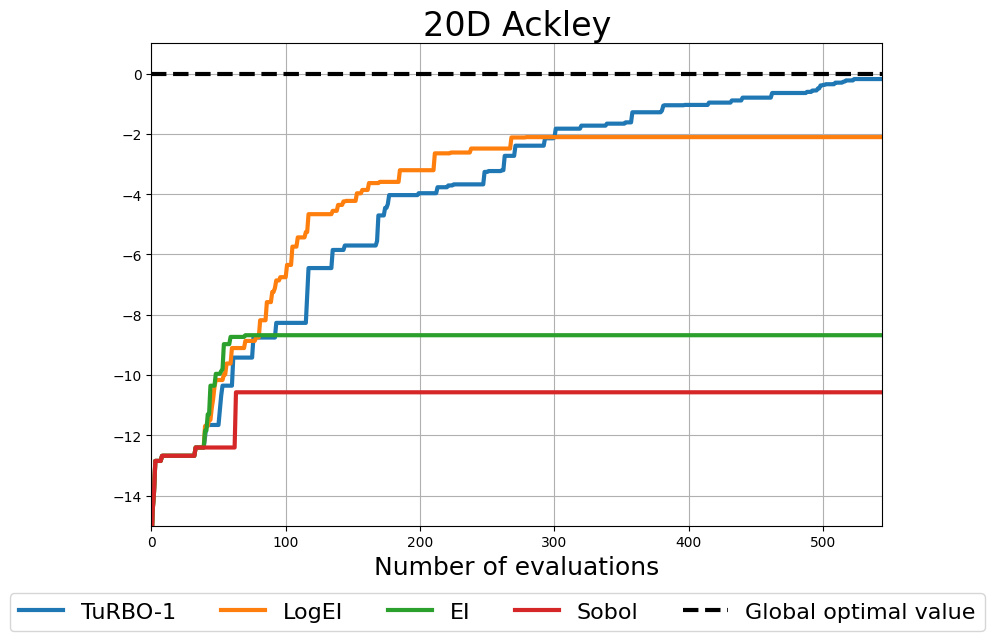

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc

%matplotlib inline


names = ["TuRBO-1", "LogEI", "EI", "Sobol"]
runs = [Y_turbo, Y_logei, Y_ei, Y_Sobol]
fig, ax = plt.subplots(figsize=(8, 6))

for name, run in zip(names, runs):
    fx = np.maximum.accumulate(run.cpu())
    plt.plot(fx, marker="", lw=3)

plt.plot([0, len(Y_turbo)], [fun.optimal_value, fun.optimal_value], "k--", lw=3)
plt.xlabel("Function value", fontsize=18)
plt.xlabel("Number of evaluations", fontsize=18)
plt.title("20D Ackley", fontsize=24)
plt.xlim([0, len(Y_turbo)])
plt.ylim([-15, 1])

plt.grid(True)
plt.tight_layout()
plt.legend(
    names + ["Global optimal value"],
    loc="lower center",
    bbox_to_anchor=(0, -0.08, 1, 1),
    bbox_transform=plt.gcf().transFigure,
    ncol=5,
    fontsize=16,
)
plt.show()